# The Audio Task
Hemanth Balaji Dandi

In [1]:
pip install textgrid

In [0]:
import numpy as np
import scipy.io
import os
import matplotlib.pyplot as plt 
import math
import librosa
from scipy.signal import hamming
from numpy.fft import rfft,fft,ifft
import IPython.display as ipd
import textgrid





## Downloading the Audio files from Drive

In [3]:
folder_id = '1-qj2Ss25n0dobpi-5Zz4_4s5_FKHwR9k' 

!pip install -U -q PyDrive

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials


# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# choose a local (colab) directory to store the data.
local_download_path = os.path.expanduser('~/data')
try:
  os.makedirs(local_download_path)
except: pass

# 2. Auto-iterate using the query syntax
#    https://developers.google.com/drive/v2/web/search-parameters
file_list = drive.ListFile(
    {'q': '\'' + folder_id + "\' in parents"}).GetList()

for f in file_list:
  # 3. Create & download by id.
  print('title: %s, id: %s' % (f['title'], f['id']))
  fname = os.path.join(local_download_path, f['title'])
  print('downloading to {}'.format(fname))
  f_ = drive.CreateFile({'id': f['id']})
  f_.GetContentFile(fname)
  
os.chdir(local_download_path)

title: shira.TextGrid, id: 1E1PLZSn9eaqIOwIDZuE_MWx_V6pLBR4-
downloading to /root/data/shira.TextGrid
title: ash.TextGrid, id: 1hFM6QICGBCSjLnuAzFyphKlI4SmFemy1
downloading to /root/data/ash.TextGrid
title: ash.wav, id: 1sSXJgX1Rbz2yU7607yqrFX3GUqWY5Ij7
downloading to /root/data/ash.wav
title: shira.wav, id: 12cxfircTCY3qLIdy1qpHO0vuI9egYtPi
downloading to /root/data/shira.wav


In [0]:
fs, ash = scipy.io.wavfile.read('ash.wav')
fs, shira = scipy.io.wavfile.read('shira.wav')

## Extracting Time-intervals and True labels from TextGrids

In [0]:
time_ash=[]
true_ash_labels=[]
time_shira=[]
true_shira_labels=[]

# Extracting the Intervals and Labels for Ash's audio
A = textgrid.TextGrid()
A.read('ash.TextGrid')
speech_ash_tier = A.getFirst('speech').intervals 

for i in range(len(speech_ash_tier)):
  
  time_ash.append(float(speech_ash_tier[i].minTime))
  if speech_ash_tier[i].mark=='speech':
    true_ash_labels.append(1)
  else:
    true_ash_labels.append(0)
    
# Extracting the Intervals and Labels for Shira's audio    
S = textgrid.TextGrid()
S.read('shira.TextGrid')
speech_shira_tier = S.getFirst('speech').intervals 

for i in range(len(speech_shira_tier)):
  
  time_shira.append(float(speech_shira_tier[i].minTime))
  if speech_shira_tier[i].mark=='speech':
    true_shira_labels.append(1)
  else:
    true_shira_labels.append(0)




Text(0.5, 1.0, "Shira's Audio")

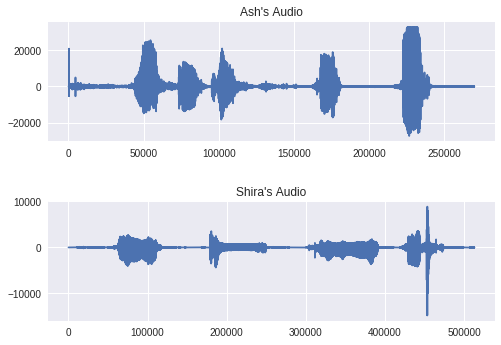

In [6]:
plt.subplots_adjust(hspace = 0.5)
plt.subplot(2,1,1)
plt.plot(ash)
plt.title("Ash's Audio")
plt.subplot(2,1,2)
plt.plot(shira)
plt.title("Shira's Audio")


In [0]:
ash=ash-(np.sum(ash)/len(ash))
ash=ash/max(abs(ash))

shira=shira-(np.sum(shira)/len(shira))
shira=shira/max(abs(shira))


In [8]:
ipd.Audio('ash.wav') # load a local WAV file

In [9]:
ipd.Audio('shira.wav') # load a local WAV file


After hearing the above voice samples, I see that there is some background noise in Ash's audio, which would be the bottleneck in any VAD model, while Shira has comparitvely less, so Shira's audio should perform well in a , say, energy VAD model, whereas for Ash's, you might need an adaptive model.

## Setting up the validation set from the Textgrid for both the Audios

In [0]:

true_shira = np.zeros(len(shira))
for i in range(len(true_shira_labels)-1):
  for j in range(int(time_shira[i]*fs),int(time_shira[i+1]*fs)):
    true_shira[j]=int(true_shira_labels[i])
    

true_ash = np.zeros(len(ash))
for i in range(len(true_ash_labels)-1):
  for j in range(int(time_ash[i]*fs),int(time_ash[i+1]*fs)):
    true_ash[j]=int(true_ash_labels[i])
    

# VADs
I have designed 3 VADs, namely, 
* **Energy-based VAD** (3 Methods)
* **Spectral Combination** (Energy + Zero Crossing Rate + Spectral Entropy) **-based** **VAD**, and
* **Spectral Centroid-based VAD**

The motivation behind each of the above VADs are listed as I go through each one-by-one, along with each of their pros and cons.

## I. Energy-based VAD

My first idea for a possible VAD solution is to use energy between frames as a possible parameter to decide between voiced and silent frames.

*  Silent frames have energy lower than some thresholded value than voiced ones, which can make distinguishing between the two very efficient and possibly less computationally expensive. 

*  How well the energy based VAD will perform depends mostly on the background noise as well, which would lead to making the threshold more adaptive, in the sense that, the threshold will depend on the energies of the previous silent frames and adapt accordingly.
*  But the principle of voiced and silent frames have greater and lower energies remains the same, it's just that we have to adapt the threshold to account for the variations in noise which could be people speaking, moving objects, microphone static, etc.

* I have 3 ideas of thesholding for each of the signals, some do well for Ash's voice , while some does well for Shira's , considering all of which I decided to go with a common one at the end. 

* Lastly, I used Short time RMS energy instead of Short time energy because thresholding was easier since the values were mapped to larger magnitudes than the latter.

Let's go into each of the methods one by one.

The Expression for Root Mean Squared (RMS) Energy is: 


\begin{equation}
E_f(i) = \sqrt{\frac{1}{N}\sum_{i=(f-1)*N}^{f*N}x_f^2(i)}
\end{equation}


In [0]:
def rms_energy(signal,dur_frame,fs):
  samples_frame = int(fs*dur_frame) # Getting the samples per frame
  frames = int(len(signal)/samples_frame) # Getting the number of frames
  
  pre_emphasis=0.8
  emp_signal = np.append(signal[0], signal[1:] - pre_emphasis * signal[:-1]) # Applying pre-emphasis to the signal

  energy = np.zeros(len(emp_signal))
  
  # Calculating the RMS Energy across every frame
  for i in range(frames):
    energy[(i*samples_frame):(i+1)*samples_frame]=np.sqrt((np.dot(emp_signal[(i*samples_frame):(i+1)*samples_frame], emp_signal[(i*samples_frame):(i+1)*samples_frame])/samples_frame))
  # Energy across the leftover samples  
  for i in range(frames*samples_frame,len(emp_signal)):
    energy[i]=np.sqrt((np.dot(emp_signal[i], emp_signal[i])/(len(emp_signal)-frames*samples_frame)))
  
  return energy

### Method 1: Energy based VAD with just a single threshold

* As the name suggests, this method seperates the voiced from silent frames through a simple threshold. 

* The threshold isn't modifed/ adaptive based on the noise per frame. 

#### Pros:


*   Worked pretty well for both Ash's and Shira's speech samples, with accuracies above 90% for both, in-fact, for Shira's speech, it has the best accuracy of 99.64% compared to any of my other methods I have tried, energy and otherwise.
*   Computationally inexpensive, in both time and space, which would prove to be very useful.

#### Cons:


*  The threshold isn't adaptive, so for highly correlated noise, it wouldn't be able to differentiate between the two.
*   Eventhough for Shira's speech sample it was able to get rid of the microphone static, but in ash's it wasn't able to, and this is because in Ash's the background noise is varying with the original speech sample so an unadaptive common threshold isn't able to seperate the noise from the voiced for all the frames, whereas for Shira's, since there is very little background noise, in the sense that, the noise is much lower than the voiced samples, a simple threshold could seperate the two distinctly.
*   As always, choosing a threshold is acheived by viewing the energy plot of the speech samples, which wouldn't be feasible in many cases.

#### Accuracies obtained:
*   Ash's audio sample got an accuracy of 90.68%
*   Shira's audio sample got an accuracy of 99.65%



In [0]:
def energy_unadapthresh(energy,dur_frame,fs,threshold):
  
  samples_frame = int(fs*dur_frame) # Getting the samples per frame
  frames = int(len(energy)/samples_frame) # Getting the number of frames
  
  energy_thresh = np.zeros(len(energy))
  
  for i in range(frames):
    if energy[i*samples_frame]<threshold:
      energy_thresh[i*samples_frame:(i+1)*samples_frame]=0
    else:
      energy_thresh[i*samples_frame:(i+1)*samples_frame]=1
 
  
  return energy_thresh
    

#### Plots for both the audio samples

##### Ash's audio sample

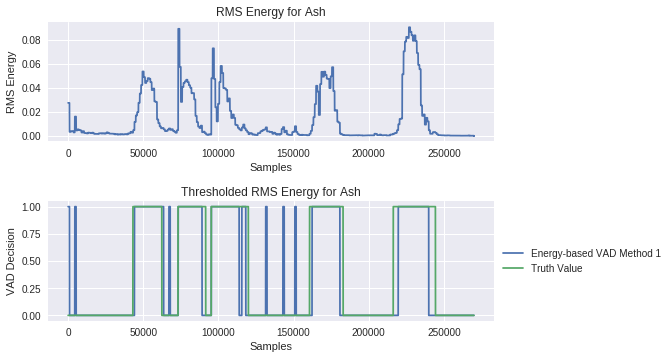

In [13]:
plt.subplots_adjust(hspace = 0.5)
plt.subplot(2,1,1)
rms_ash = rms_energy(ash,0.02,fs)
plt.plot(rms_ash)
plt.xlabel('Samples')
plt.ylabel('RMS Energy')
plt.title('RMS Energy for Ash')
ax = plt.subplot(2,1,2)
thresh_ash = energy_unadapthresh(rms_ash,0.02,fs,0.006)
plt.plot(thresh_ash,label='Energy-based VAD Method 1')
plt.plot(true_ash,label='Truth Value')
plt.xlabel('Samples')
plt.ylabel('VAD Decision')
plt.title('Thresholded RMS Energy for Ash')
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 1, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()
#plt.legend(loc='upper right')




##### Shira's audio sample

/usr/local/lib/python3.6/dist-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


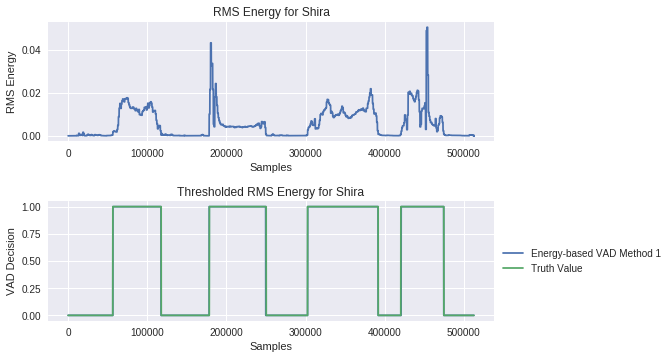

In [14]:
plt.subplots_adjust(hspace = 0.5)
plt.subplot(2,1,1)
rms_shira = rms_energy(shira,0.02,fs)
plt.plot(rms_shira)
plt.xlabel('Samples')
plt.ylabel('RMS Energy')
plt.title('RMS Energy for Shira')
ax = plt.subplot(2,1,2)
plt.subplot(2,1,2)
thresh_shira = energy_unadapthresh(rms_shira,0.02,fs,0.0018) #<-99.65 Simple Threshold
plt.plot(thresh_shira,label='Energy-based VAD Method 1')
plt.plot(true_shira,label='Truth Value')
plt.xlabel('Samples')
plt.ylabel('VAD Decision')
plt.title('Thresholded RMS Energy for Shira')
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 1, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))


#### Accuracies' of both the plots


*   Ash's audio sample got an accuracy of 90.68%
*   Shira's audio sample got an accuracy of 99.65%



In [0]:
def accuracy(true,predicted): # Function to calculate Accuracy, F1-Score and Missclassifcation Error
  
  #Accur = np.sum(true==predicted)/len(true)
  true_positive = sum((true == 1) & (predicted == 1))
  true_negative = sum((true == 0) & (predicted == 0))
  false_positive = sum((true == 0) & (predicted == 1))
  false_negative = sum((true == 1) & (predicted == 0))
  
  precision = true_positive/(true_positive+false_positive)
  recall = true_positive/(true_positive+false_negative)
  
  F1 = 2*precision*recall/(precision+recall)
  Accu = (true_positive+true_negative)/(true_positive+true_negative+false_positive+false_negative)
  Missclass = (false_positive+false_negative)/(true_positive+true_negative+false_positive+false_negative)
  
  return Accu,F1,Missclass
  

In [16]:
accuracy_ash,F1_score_ash,missclassifcation_ash = accuracy(true_ash,thresh_ash)
accuracy_shira,F1_score_shira,missclassifcation_shira = accuracy(true_shira,thresh_shira)
print('Ash-> Energy VAD-Model 1 (Unadaptive threshold)')
print('Accuracy',accuracy_ash)
print('F1 Score',F1_score_ash)
print('Missclassifcation Score',missclassifcation_ash)
print('--------------------------------------------------')
print('Shira-> Energy VAD-Model 1 (Unadaptive threshold)')
print('Accuracy',accuracy_shira)
print('F1 Score',F1_score_shira)
print('Missclassifcation Score',missclassifcation_shira)


Ash-> Energy VAD-Model 1 (Unadaptive threshold)
Accuracy 0.9067758947617919
F1 Score 0.8819878105954055
Missclassifcation Score 0.09322410523820811
--------------------------------------------------
Shira-> Energy VAD-Model 1 (Unadaptive threshold)
Accuracy 0.9964837899400899
F1 Score 0.9967322808244874
Missclassifcation Score 0.0035162100599101347


### Method 2: Energy based VAD with an adaptive threshold and a limiting energy factor.

The main idea behind this method is making the threshold value more adaptive and 'localized' so as to make robust decisions.

* This method improves on the previous Method 1 by learning it's threshold value through previous silent and noisy frames, such a way that the threshold will reflect mostly the influence of the recent silent frames and less influence of the ones that occurred much before. 
The threshold value is weighted by a constant value, **'weight'** entered as input by us.

* The second parameter this method uses is **'Emin'**, a minimum energy factor, which is so as to avoid low energy silent frames being tagged as speech., so it's like a limiting factor to avoid miss-classification.

* A third parameter, is introduced as well inside the function, which is called **'inactive'**, because I realized in the many miss-classifications in the previous method occured because the threshold provided a hard stop , ie, when a person stops talking, the energy doesn't drop immediately in that frame, it gradually falls after a couple of frames. So I introduced a parameter, which basically acts like a flag: If, just after a voice frame is detected, the algorithm says the next frame is unvoiced (as it falls below the threshold), let a next few unvoiced frames be forced as voiced, and when the parameter reaches the optimum number of frames, let the algorithm resume it's rule.  

*  Initially the threshold value is initilaized with the mean of energy values for about 10 frames, as it was an initialization that made more sense than a 0 or just the first frame, as before speaking, the person needs time, and it's a reasonable assumption as it worked for the two audio samples.

  . 

#### Pros:

*   Worked again pretty well for both Ash's and Shira's speech samples, with accuracies above 95% for both, but what it impressed was that it got rid of the initial microphone static in Ash's speech, which was primarily because of the role of the adaptive threshold.
*   Computationally, I would say it is definetely more expensive than Method 1, but since it's more adaptive and flexible, I think it is justified.

#### Cons:
*   We have to choose 2 parameters, first for the constant weightage parameter for teh threshold and the second for the limiting factor. 
*   The value of threshold was initialized for the first 10 frames being background noise, so that the threhold can adapt much better and hence remove the microphone static present in both the audio samples. However, this might not work in all cases.
* It is more computationally expensive than Method 1 and involves twice as many as variables, which increases the space complexity.

#### Accuracies
*   Ash's audio sample got an accuracy of 95.577%
*   Shira's audio sample got an accuracy of 98.36%



In [0]:
def energy_adapthresh(energy,dur_frame,fs,weight,Emin):
  samples_frame = int(fs*dur_frame) # Samples per frame
  frames = int(len(energy)/samples_frame) # Number of frames
  
  energy_athresh = np.zeros(len(energy))
  threshold = np.mean(energy[0:10*samples_frame]) # Initializing with the average energy of the first 10 frames
  inactive = 0
  for i in range(10,frames):
    if energy[i*samples_frame]<=weight*threshold and energy[i*samples_frame]<Emin: # Silent frame condition
      Esil = energy[i*samples_frame]
      if energy_athresh[(i-1)*samples_frame]==1 and inactive<2: # Checking if, just after a speech frame, there is a buffer of
        # a frame, before the algorithm applies it's threshold value 
        inactive+=1
        energy_athresh[i*samples_frame:(i+1)*samples_frame]=1
        threshold = (threshold + Esil)/2 # Averaging the previous silent and the current threshold energy values
        continue
              
      energy_athresh[i*samples_frame:(i+1)*samples_frame]=0
      threshold = (threshold  + Esil)/2 # Averaging the previous silent and the current threshold energy values
      inactive=0
      
    else:
   
      energy_athresh[i*samples_frame:(i+1)*samples_frame]=1 # Speech frame condition
      inactive=0 
      
  plt.plot(energy_athresh)
  
  return energy_athresh
    
  

#### Plots for both the Audio samples

##### Ash's Audio

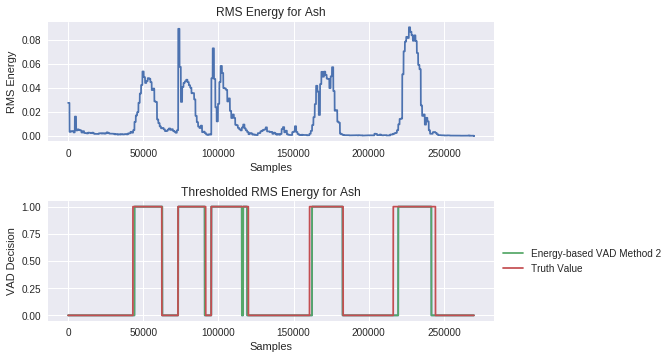

In [18]:
plt.subplots_adjust(hspace = 0.5)
plt.subplot(2,1,1)
rms_ash = rms_energy(ash,0.02,fs)
plt.plot(rms_ash)
plt.xlabel('Samples')
plt.ylabel('RMS Energy')
plt.title('RMS Energy for Ash')
ax = plt.subplot(2,1,2)
athresh_ash = energy_adapthresh(rms_ash,0.02,fs,4.5,0.0085)
plt.plot(athresh_ash,label='Energy-based VAD Method 2')
plt.plot(true_ash,label='Truth Value')
plt.xlabel('Samples')
plt.ylabel('VAD Decision')
plt.title('Thresholded RMS Energy for Ash')
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 1, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))



##### Shira's Audio

/usr/local/lib/python3.6/dist-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


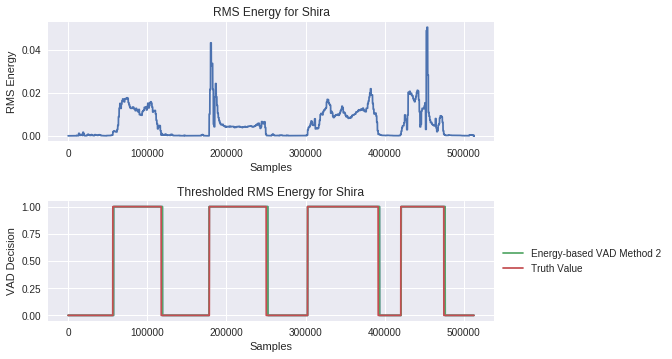

In [19]:
plt.subplots_adjust(hspace = 0.5)
plt.subplot(2,1,1)
rms_shira = rms_energy(shira,0.02,fs)
plt.plot(rms_shira)
plt.xlabel('Samples')
plt.ylabel('RMS Energy')
plt.title('RMS Energy for Shira')
ax = plt.subplot(2,1,2)
plt.subplot(2,1,2)
athresh_shira = energy_adapthresh(rms_shira,0.02,fs,8,0.002) 
plt.plot(athresh_shira,label='Energy-based VAD Method 2')
plt.plot(true_shira,label='Truth Value')
plt.xlabel('Samples')
plt.ylabel('VAD Decision')
plt.title('Thresholded RMS Energy for Shira')
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 1, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))


#### Accuracies' of both the plots


*   Ash's audio sample got an accuracy of 95.577%
*   Shira's audio sample got an accuracy of 98.36%

In [20]:
accuracy_ash,F1_score_ash,missclassifcation_ash = accuracy(true_ash,athresh_ash)
accuracy_shira,F1_score_shira,missclassifcation_shira = accuracy(true_shira,athresh_shira)
print('Ash-> Energy VAD-Model 2 (Adaptive threshold)')
print('Accuracy',accuracy_ash)
print('F1 Score',F1_score_ash)
print('Missclassifcation Score',missclassifcation_ash)
print('--------------------------------------------------')
print('Shira-> Energy VAD-Model 2 (Adaptive threshold)')
print('Accuracy',accuracy_shira)
print('F1 Score',F1_score_shira)
print('Missclassifcation Score',missclassifcation_shira)


Ash-> Energy VAD-Model 2 (Adaptive threshold)
Accuracy 0.9557729912301494
F1 Score 0.944243680608081
Missclassifcation Score 0.044227008769850674
--------------------------------------------------
Shira-> Energy VAD-Model 2 (Adaptive threshold)
Accuracy 0.9836046711183225
F1 Score 0.9849557189562952
Missclassifcation Score 0.016395328881677485


### Method 3: Energy based VAD with just an adaptive threshold

This method looks to improve the previous method by being a lot more adaptive. The idea is all that of Method 2, but in addition:

(a) Make the weight for the threshold in the previous method adaptive through using Emax and Emin, where **Emax** and **Emin** are the Maximum and minimum energies encountered from the previous frames.
More specifically, 
\begin{equation}
k=(Emax-Emin)/Emax
\end{equation}

(b) Now, the threshold is based on the weight from (a), Emax and Emin, which should make it more robust. So instead of the threshold depending upon the average between the previous silent frame and the current threshold, this threshold is more locally oriented,
\begin{equation}
threshold = (1-k)*Emax + k*Emin
\end{equation}

(c) The goal here was to try to reduce the choosing of parameters by making all of them adaptive.

(d)
* Two parameters are chosen, one for initializing Emin, **'Emin_init'**, but , unlike Method 2, this Emin changes based on the frames being voiced/silent.
* And the other parameter, '**delta**' that is used to modify Emin to make the the threshold more adaptive. The idea is, in cases when Emin becomes close to 0, then the threshold wouldn't change by that much, which would make it constant and low enough to missclassify silent as voiced, thus we need to change Emin ever so slightly to prevent this from happening.

#### Pros:

*   Worked again pretty well for both Ash's and Shira's speech samples, with accuracies above 90% for both, but not as good as I would have expected it to.
But the idea was trying to make the parameters more adaptive according to the frames, so, I think, with obviosly improvement, this could do well in cases where Emin isn't clearly seperable.
*   Computationally,  definitely it's the most expensive than the above two, but since it's even more adaptive which I believe is more interesting and could be more productive.

#### Cons:
*   We have to choose 2 parameters, first for 'delta', which is the amount of change you want Emin to change , and Emin, which initializes it before being adaptive with delta, and therefore affecting the threshold after each frame. 
*  Emax was initialzed to the first 10 frames , same reason as that users would take time to record, and it's an appropriate assumption, but in these two cases. There are obviously cases where this could fail, but I think it is reasonable.
* It is most computationally expensive both in time and space, but again, as we want to make the parameters more adaptive with the frames, it is required for this case.

#### Accuracies
*   Ash's audio sample got an accuracy of 95.47%
*   Shira's audio sample got an accuracy of 98.32%



In [0]:
def energy_adapthresh_mod(energy,dur_frame,fs,delta,Emin_init):

  samples_frame = int(fs*dur_frame) # Samples per frame
  frames = int(len(energy)/samples_frame) # Number of frames
  
  energy_athresh_mod = np.zeros(len(energy))
  
  Emax = np.mean(energy[0:10*samples_frame]) # Emax initialized as the mean energy value across first 10 frames
  Emin=[Emin_init]*frames # Emin initialized with input Emin_init
  Delta=[delta]*frames # Delta initialized with 'delta' to moderate Emin value
  inactive = 0
  
  for i in range(10,frames):
 
    if energy[i*samples_frame]>Emax : # Emax value being found
      Emax=energy[i*samples_frame]
      
    elif energy[i*samples_frame]<Emin[i]: # Emin value being found
      if energy[i*samples_frame]==0: # If Energy is 0, re-initialize Emin[i] and Delta
        Emin[i]=Emin_init
        Delta[i] = delta
      else:
        Emin[i]=energy[i*samples_frame]
    
    Delta[i]=delta
      
    k= abs((Emax-Emin[i])/Emax) # Weight for the threshold, ie, weightage of how much should Emin and Emax weigh in the threshold
  
    threshold = abs((1-k)*Emax + k*Emin[i]) # The threshold
        
    if energy[i*samples_frame]> threshold: # Speech condition
      energy_athresh_mod[i*samples_frame:(i+1)*samples_frame]=1
    elif energy[i*samples_frame]< threshold: # Silent frame condition
      if energy_athresh_mod[(i-1)*samples_frame]==1 and inactive<3: # If the previous frame is speech, and buffer frames are not met, assign it as speech
        inactive+=1
        energy_athresh_mod[i*samples_frame:(i+1)*samples_frame]=1
      else:
        energy_athresh_mod[i*samples_frame:(i+1)*samples_frame]=0 # If the buffer condition is met, and frames still fall below the threshold, it's silent
        inactive=0
       
    Emin[i]= Emin[i-1]*Delta[i] # Change Emin by a small amount so that the threshold wouldn't be kept constant and low throughout
    Delta[i]=Delta[i-1]*1.0001 # Update Delta values
      
  plt.plot(energy_athresh_mod)
  
  return energy_athresh_mod
    
  

#### Plots for both the Audio samples

##### Ash's audio

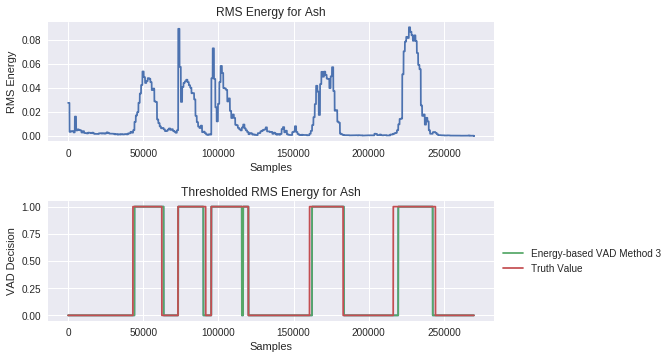

In [22]:
plt.subplots_adjust(hspace = 0.5)
plt.subplot(2,1,1)
rms_ash = rms_energy(ash,0.02,fs)
plt.plot(rms_ash)
plt.xlabel('Samples')
plt.ylabel('RMS Energy')
plt.title('RMS Energy for Ash')
ax = plt.subplot(2,1,2)
a_mod_thresh_ash = energy_adapthresh_mod(rms_ash,0.02,fs,20,0.0044)
plt.plot(a_mod_thresh_ash,label='Energy-based VAD Method 3')
plt.plot(true_ash,label='Truth Value')
plt.xlabel('Samples')
plt.ylabel('VAD Decision')
plt.title('Thresholded RMS Energy for Ash')
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 1, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))



##### Shira's audio

/usr/local/lib/python3.6/dist-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


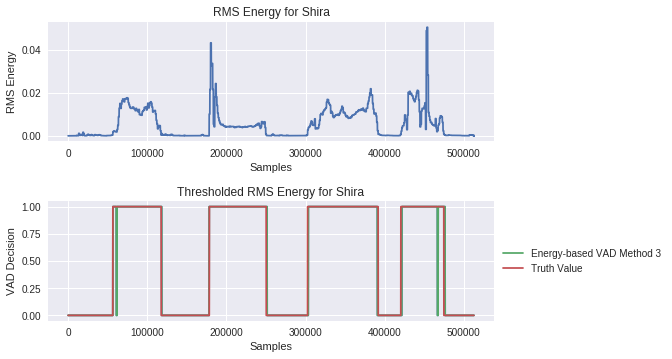

In [23]:
plt.subplots_adjust(hspace = 0.5)
plt.subplot(2,1,1)
rms_shira = rms_energy(shira,0.02,fs)
plt.plot(rms_shira)
plt.xlabel('Samples')
plt.ylabel('RMS Energy')
plt.title('RMS Energy for Shira')
ax = plt.subplot(2,1,2)
plt.subplot(2,1,2)
a_mod_thresh_shira = energy_adapthresh_mod(rms_shira,0.02,fs,0.001,0.00185) 
plt.plot(a_mod_thresh_shira,label='Energy-based VAD Method 3')
plt.plot(true_shira,label='Truth Value')
plt.xlabel('Samples')
plt.ylabel('VAD Decision')
plt.title('Thresholded RMS Energy for Shira')
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 1, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))


#### Accuracies' of both the plots


*   Ash's audio sample got an accuracy of 95.47%
*   Shira's audio sample got an accuracy of 98.32%

In [24]:
accuracy_ash,F1_score_ash,missclassifcation_ash = accuracy(true_ash,a_mod_thresh_ash)
accuracy_shira,F1_score_shira,missclassifcation_shira = accuracy(true_shira,a_mod_thresh_shira)
print('Ash-> Energy VAD-Model 3 (Modified Adaptive threshold)')
print('Accuracy',accuracy_ash)
print('F1 Score',F1_score_ash)
print('Missclassifcation Score',missclassifcation_ash)
print('--------------------------------------------------')
print('Shira-> Energy VAD-Model 3 (Modified Adaptive threshold)')
print('Accuracy',accuracy_shira)
print('F1 Score',F1_score_shira)
print('Missclassifcation Score',missclassifcation_shira)


Ash-> Energy VAD-Model 3 (Modified Adaptive threshold)
Accuracy 0.9547360156435174
F1 Score 0.943632741158891
Missclassifcation Score 0.04526398435648258
--------------------------------------------------
Shira-> Energy VAD-Model 3 (Modified Adaptive threshold)
Accuracy 0.9831990295806291
F1 Score 0.9843863556866107
Missclassifcation Score 0.016800970419370943


### Conclusion 
Here is a basic synopsis of the various RMS Energy based methods
* Method 1 just employed a single threshold

* Method 2 employed an adaptive threshold, where

  (a) The threshold varied based on the average of the previous silent frame and the current threshold

  (b) The threshold condition is weighted by a **weight** we supply as input

  (c) There is also a limiting factor **Emin** we supply as input so as to give an added limiting factor for the silent frame.
  
  (d) There is also a parameter, **inactive** to control the amount of hangover frames where, if the previous frame is speech, and if the energy falls below the threshold, it will be marked as silent if and only if the number of buffer frames have been exceeded
  
* Method 3 also employed adaptive threshold, a modification of Method2, as 

  (a) The **weight** parameter is now based on Emax and Emin of the frames, so as to make the thresholding more temporal and local
  
   (b) The threshold is based on the weighted Emax and Emin
   
   (c) A **delta** parameter is introduced so as to increase Emin very slowly so as to avoid from weight from going to 0.
   
### Accuracies Summary :

   
| Energy-based VAD Model  | Person  | Accuracy(%) | F1-Score(%) | Missclass Error(%)|
| --- | --- | --- | --- | --- |
| **Model 1** (with a simple threshold) | Shira | 99.65 |99.67  |0.35
|  | Ash | 90.68 | 88.2 | 9.32|
| **Model 2** (adaptive threshold, manual weightage, | Shira | 98.36 | 98.5 | 1.64 |
| manual minimum energy, hangover limit) | Ash | 95.58  | 94.42  |4.42 |
| **Model 3** (adaptive threshold, adaptive weightage, | Shira | 98.32 | 98.44 | 1.68 |
|adaptive minimum energy, hangover limit)  | Ash |95.47  | 94.36  | 4.53 | 

### Performance -Discussion:
* Clearly, Method 1 is much less computationally expensive than the other two, then Method 2 , and then Method 3. This is because of the methods become more and more adaptive, which requires more computation.
* That being said, Method 1's accuracy is much easier to fail with a slightly more noisy speech sample than the other two because of the simplistic threshold condition.
* I expected Method 3 to perform better than Method 2, but I think I have to work on it a bit more. Since the threshold is more adaptive than Method 2, I believe the algorithm can become more robust to handle more noisy speech samples.

### Best Energy VAD:
Based from the accuracies, especially the F1-score and the Missclassification error, in which the latter is the number of wrongly predicted frames, and how each method's algorithm will behave for a more complicated signal,
I would prefer the VAD based on Method 2, because of the threshold being adaptive. For now, I wouldn't go with Method 3, because I know it isn't optimized , so, **Method 2** is the best VAD to handle a generalized audio. The missclassification error for Ash's signal is the least for Method2, while Shira's isn't that bad, but most importantly, as it's threshold is adaptive, it can behave flexibly with more complicated signals

### Limitations:
* I think, eventhough the models did perform well for the given speech samples, energy models would not do so well if the SNR of the signal were to less, so probably we need to look into another method. 
That was partly my motivation for the next VAD approach, where I figured, maybe a single feature isn't enough to seperate speech samples, but a combination of different could make it a bit more robust to signals with decreasing SNR.






In [25]:
ipd.Audio(athresh_ash*ash, rate=fs)

In [26]:
ipd.Audio(athresh_shira*shira, rate=fs)

## II. Spectral Combination-based VAD (Energy + Zero Crossing Rate + Spectral Entropy) 


The motivation behind this was that, instead of using a single spectral feature, probably a combination of spectral features which are useful to seperate silent and speech frames would lead to a better decision.  

### Zero Crossing Rate
Since the Zero crossing rate the number of times the signal crosses the time-domain axis, ie, the amount of times the signals amplitude switches signs in a segment, the idea that if the amount is more, then it is likely to be an silent frame and if it isn't, it is going to be a speech frame.

The Expression for Zero Crossing rate is:

\begin{align}
Z_f = \frac{1}{N}\sum_{i=-\infty}^{\infty}|sgn[x(i)]-sgn[x(m-1)]|
\\ where
\\ sgn[x(i)] = 
\begin{cases}
  1 &; \> \text{if }x\ge 0\\    
  -1 &; \> \text{if }x< 0\\ 
\end{cases}
\end{align}


### Spectral Entropy
Spectral entropy refers to the average amount of information contained in a signal/frame. Since speech frames are expected to contain more information than silent frames, it can be a useful factor to seperate the two.

The Expression for Spectral Entropy is:
\begin{align}
H(x) = -\sum_{i=1}^{n}P(x(i))\log_2(P(x(i)))
\end{align}
where
\begin{align}
P(x(i)) \> \text{is the Probability Density Function of } x(i)
\end{align}

Using the 3 factors, Energy, Zero-Crossing rate and Spectral Entropy, a decision can be made through combining them to decide if a frame is silent/speech.
It's like how Adaptive Boosting works, we take a bunch of weak learners and combine to form a strong one, in this case a VAD based on combining the 3.

So, the outline of the algorithm is pretty straightforward-
*   Find the energy of the signal (E)
*   Find the Zero Crossing rate of the signal (ZCR)
*  Find the spectral entropy of the signal (SE)
*  Make a Decision by combing the 3 as:

\begin{equation}
D = E*(1-ZCR)*(SE)
\\ \text{and normalize with} \> Dmax
\end{equation}

* Thresholding is more or less similar to what is employed in Method 2 of Energy VAD, except I didn't put the flag for keeping the 'hangover'  frames in check. I just wanted to see whether this would work, fine-tuning wasn't the goal here.

\begin{align}
x_f(n) \rightarrow
\begin{cases}
  Speech & ; \> \text{if }\frac{D}{Dmax}  \ge \text{threshold}\\    
  Silent & : \> otherwise\\ 
\end{cases}
\end{align}



#### Pros
* All the algorithms are aren't computationally expensive to implement individually, so as for decisions made with combing features, these are more or less efficient
* Accuracies for both the samples are good as well, with Shira's being even higher than the highest of the Energy-based VAD, and in both the signals, this VAD managed to rid of the initial microphone noise.

#### Cons
* With very low SNR signals, this exact VAD as is wouldn't do that well as both Energy and Zero Crossing rates would be compromised, but I think a these are the right features, a bit of modifications would make it good, or probably adding a couple more features like Pitch.
* We are still using 2 parameters as input, which isn't as ideal as it would seem.

#### Accuracy
*   Ash's audio sample got an accuracy of 92.54%
*   Shira's audio sample got an accuracy of 99.72%

#### Zero Crossing Rate

In [0]:
def zero_crossing_rate(signal,dur_frame,fs):
  samples_frame = int(fs*dur_frame) # Samples per frame
  frames = int(len(signal)/samples_frame) # Number of frames
  
  pre_emphasis=0
  emp_signal = np.append(signal[0], signal[1:] - pre_emphasis * signal[:-1]) # Pre-emphasis
  
  zcr = np.zeros(len(emp_signal))
  
  z=0
  for i in range(frames):
    for j in range(samples_frame-1):    
      if (np.sign(emp_signal[i*samples_frame+j]) - np.sign(emp_signal[i*samples_frame+(j+1)])) !=0: # Checking number of switched amplitude signs
        z+=1
    zcr[i*samples_frame:(i+1)*samples_frame]=z/samples_frame
    z=0
  
  leftover_samples = len(emp_signal)-frames*samples_frame
  
  z=0
  for i in range(frames*samples_frame,len(emp_signal)-1):
    if (np.sign(emp_signal[i]) - np.sign(emp_signal[i+1])) !=0:
        z+=1   
  zcr[frames*samples_frame:len(emp_signal)]=z/leftover_samples      
  
  return zcr
  
def zerothresh(y,frames,th):
  thresh = np.zeros(len(y))

  for i in range(frames):
    if y[i*882]> th:
      thresh[i*882:(i+1)*882]=1
  
  return thresh

#### Spectral Entropy

In [0]:
def spectral_entropy(signal,dur_frame,fs):
  samples_frame = int(fs*dur_frame)
  frames = int(len(signal)/samples_frame)
  
  pre_emphasis=0
  emp_signal = np.append(signal[0], signal[1:] - pre_emphasis * signal[:-1])
  
  spec_entrp = np.zeros(len(emp_signal))
  
  for i in range(frames):
    sig=emp_signal[i*samples_frame:(i+1)*samples_frame]*np.hamming(samples_frame) # Windowing with Hamming
    psd = np.abs(rfft(sig))**2 # Calculating Power Spectral Density
    psd_normalized = psd/np.sum(psd) # Normalizing PSD
    # Spectral Entropy
    spec_entrp[i*samples_frame:(i+1)*samples_frame] = -1*(np.sum(psd_normalized*np.log2(psd_normalized+1e-12)))/(np.log2(len(psd_normalized)))
    
  leftover_samples = len(emp_signal)-frames*samples_frame
  
  sig = emp_signal[frames*samples_frame:len(emp_signal)]*np.hamming(leftover_samples)
  psd = np.abs(rfft(sig))**2
  psd_normalized = psd/np.sum(psd)
  spec_entrp[frames*samples_frame:len(emp_signal)] = -1*(np.sum(psd_normalized*np.log2(psd_normalized)))/(np.log2(len(psd_normalized)))
    
                  
  return spec_entrp
 

#### Combining RMS Enegy, ZCR and Spectral Entropy to make a Decision for the VAD

In [0]:
def energy_zcr_entropy(signal,dur_frame,fs,weight,Dmin):
  samples_frame = int(fs*dur_frame)
  frames = int(len(signal)/samples_frame)
  
  pre_emphasis=0.8
  emp_signal = np.append(signal[0], signal[1:] - pre_emphasis * signal[:-1])
  
  enzcrtropy = np.zeros(len(emp_signal))
  
  # Decision
  D = rms_energy(signal,dur_frame,fs)*(1-zero_crossing_rate(emp_signal,dur_frame,fs)*spectral_entropy(emp_signal,dur_frame,fs))
  # Normalizing the Decision
  Dmax = np.max(D)
  
  Decision = D/Dmax 
  
  threshold = np.mean(Decision[0:10*samples_frame]) # Initialing with the average first 10 frames
  
  for i in range(10,frames):
    if Decision[i*samples_frame]<threshold*weight and Decision[i*samples_frame]<Dmin : # Condition for silent frames
      Dsil = Decision[i*samples_frame] # Decision of the silent frame
      enzcrtropy[i*samples_frame:(i+1)*samples_frame]=0
      threshold = (threshold  + Dsil)/2 # Threshold averaged between the Decision of silent and the current threshold
    else:
      enzcrtropy[i*samples_frame:(i+1)*samples_frame]=1  # Speech sample
    
  
  return Decision, enzcrtropy
    
  

#### Plots

##### Ash's audio

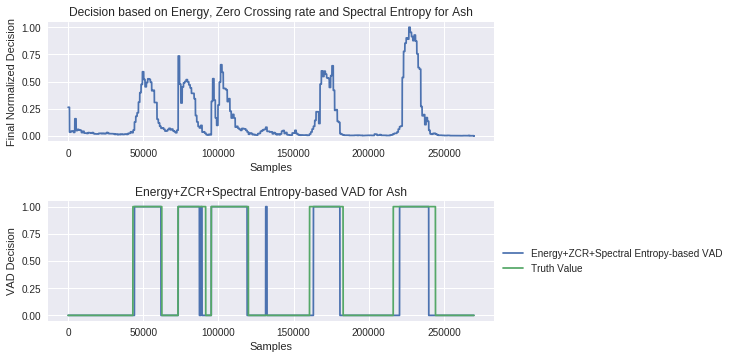

In [30]:
plt.subplots_adjust(hspace = 0.5)
plt.subplot(2,1,1)
enzcrtropy_ash , enzcrtropy_thresh_ash= energy_zcr_entropy(ash,0.02,fs,3.6,0.08) 
plt.plot(enzcrtropy_ash)
plt.xlabel('Samples')
plt.ylabel('Final Normalized Decision')
plt.title('Decision based on Energy, Zero Crossing rate and Spectral Entropy for Ash')
ax = plt.subplot(2,1,2)
plt.plot(enzcrtropy_thresh_ash,label='Energy+ZCR+Spectral Entropy-based VAD')
plt.plot(true_ash,label='Truth Value')
plt.xlabel('Samples')
plt.ylabel('VAD Decision')
plt.title('Energy+ZCR+Spectral Entropy-based VAD for Ash')
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 1, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))


##### Shira's audio

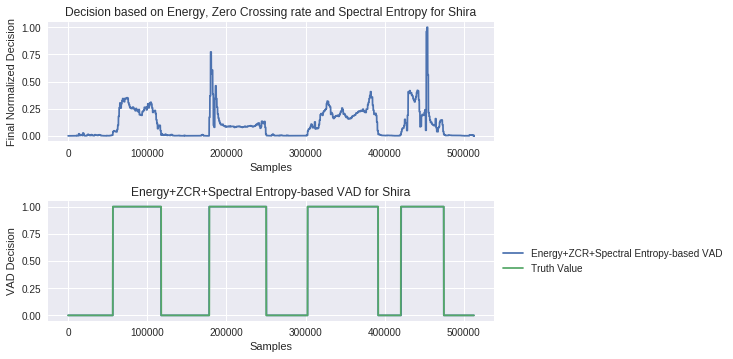

In [31]:
plt.subplots_adjust(hspace = 0.5)
plt.subplot(2,1,1)
enzcrtropy_shira , enzcrtropy_thresh_shira= energy_zcr_entropy(shira,0.02,fs,8,0.029) 
plt.plot(enzcrtropy_shira)
plt.xlabel('Samples')
plt.ylabel('Final Normalized Decision')
plt.title('Decision based on Energy, Zero Crossing rate and Spectral Entropy for Shira')
ax = plt.subplot(2,1,2)
plt.plot(enzcrtropy_thresh_shira,label='Energy+ZCR+Spectral Entropy-based VAD')
plt.plot(true_shira,label='Truth Value')
plt.xlabel('Samples')
plt.ylabel('VAD Decision')
plt.title('Energy+ZCR+Spectral Entropy-based VAD for Shira')
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 1, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))


#### Accuracies' of the two audio samples

*   Ash's audio sample got an accuracy of 92.54%
*   Shira's audio sample got an accuracy of 99.72%

In [32]:
accuracy_ash,F1_score_ash,missclassifcation_ash = accuracy(true_ash,enzcrtropy_thresh_ash)
accuracy_shira,F1_score_shira,missclassifcation_shira = accuracy(true_shira,enzcrtropy_thresh_shira)
print('Ash-> Spectral Combination VAD- (Energy+ZCR+Entropy) (Adaptive threshold)')
print('Accuracy',accuracy_ash)
print('F1 Score',F1_score_ash)
print('Missclassifcation Score',missclassifcation_ash)
print('--------------------------------------------------')
print('Shira-> Spectral Combination VAD- (Energy+ZCR+Entropy) (Adaptive threshold)')
print('Accuracy',accuracy_shira)
print('F1 Score',F1_score_shira)
print('Missclassifcation Score',missclassifcation_shira)


Ash-> Spectral Combination VAD- (Energy+ZCR+Entropy) (Adaptive threshold)
Accuracy 0.9254044204787865
F1 Score 0.9027548448770313
Missclassifcation Score 0.07459557952121355
--------------------------------------------------
Shira-> Spectral Combination VAD- (Energy+ZCR+Entropy) (Adaptive threshold)
Accuracy 0.9971897622316526
F1 Score 0.997392530078188
Missclassifcation Score 0.0028102377683474787


### Accuracy Summary

| Spectral Combination VAD Model  | Person  | Accuracy(%) | F1-Score(%)|Missclassifcation Score (%)|
| --- | --- | --- |--- | --- | 
| RMS Energy + Zero Crossing Rate + Spectral Entropy | Shira | 99.72 | 99.74 |0.28 |
|  | Ash | 92.54 | 90.27 | 7.46|


### Conclusion
* This VAD performed pretty well, though not good enough for Ash's speech sample. I think a much more robust threshold decision is required, because, for high SNR signals, this detector would work.
* I think the major difference between the Energy based VAD and the this VAD is, due to a combination of features for the decision made by this VAD, it would do much better than the energy VAD for decreasing SNR signals.
* The Missclassification error for Shira's audio is pretty good, which does prove that combining features do make the decision robust, but choosing that decision is also very important, as can be seen from the missclassifcation error from Ash's audio

## III. Spectral Centroid-based VAD

This was just an idea that average loudness would be a good feature for this case. I believe that, not on it's own, but with a combination with other features, could lead to a robust VAD.

I used a simple threshold for this case, as I wanted to see how well it would perform with just that, so if it did do reasonably well, maybe I could adapt the threshold.

Since spectral centroid provides the center of mass for the signal/frame, which, intuitively , means it's average loudness per frame, I figured this could be used especially in these two cases where the silent frames will have lower average loudness. 

The Expression for Spectral Centroid is:

\begin{equation}
 C(f)  = \sum_{k=1}^{N}\frac{kX_f[k]}{\sum_{k=1}^{N}{X_f[k]}}
\\ \text{where }
\\ X_f[k] \>   \text{is the Amplitude of the DFT of} \> x_f(n) \> \text{at bin } \> k
\end{equation}

In [0]:
def spec_centroid(signal,dur_frame,fs):
  samples_frame = int(fs*dur_frame)
  frames = int(len(signal)/samples_frame)
  
  pre_emphasis=0.5
  emp_signal = np.append(signal[0], signal[1:] - pre_emphasis * signal[:-1])
  
  spec_cent = np.zeros(len(signal))
  
  for i in range(frames):
    sig=emp_signal[i*samples_frame:(i+1)*samples_frame]*np.hamming(samples_frame) # Windowing
    s = np.abs(rfft(sig)) # First half of FFT
    freq = np.abs(np.fft.fftfreq(samples_frame,1/fs))[:int(samples_frame/2)+1] # Storing the bins
   
    spec_cent[i*samples_frame:(i+1)*samples_frame] = np.sum(s*freq) / np.sum(s) # Finding the centroid
  
  leftover_samples = len(emp_signal)-frames*samples_frame
  
  sig = emp_signal[frames*samples_frame:len(emp_signal)]*np.hamming(leftover_samples)
  s = np.abs(rfft(sig))
  freq = np.abs(np.fft.fftfreq(leftover_samples,1/fs))[:int(leftover_samples/2)+1]
   
  spec_cent[frames*samples_frame:len(emp_signal)] = np.sum(s*freq) / np.sum(s)    
                  
  return spec_cent

In [0]:
def specthresh(centroid,dur_frame,fs,threshold):
  samples_frame = int(fs*dur_frame)
  frames = int(len(centroid)/samples_frame)
  
  spec_thresh = np.zeros(len(centroid))
  for i in range(frames):
    if centroid[i*samples_frame]>threshold:
      spec_thresh[i*samples_frame:(i+1)*samples_frame]=1
      
  if centroid[frames*samples_frame]>threshold:
    spec_thresh[frames*samples_frame:len(centroid)]=1
       
  return spec_thresh
    

#### Plots of the audio files

#### Ash's audio

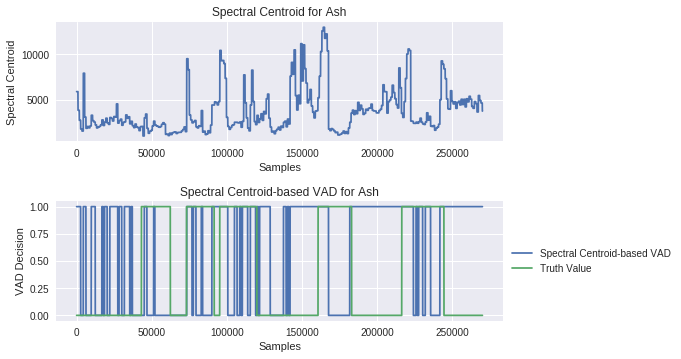

In [35]:
plt.subplots_adjust(hspace = 0.5)
plt.subplot(2,1,1)
spec_ash= spec_centroid(ash,0.02,fs)
plt.plot(spec_ash)
plt.xlabel('Samples')
plt.ylabel('Spectral Centroid')
plt.title('Spectral Centroid for Ash')
thresh_cent_ash = specthresh(spec_ash,0.02,fs,2500)
ax = plt.subplot(2,1,2)
plt.plot(thresh_cent_ash,label='Spectral Centroid-based VAD')
plt.plot(true_ash,label='Truth Value')
plt.xlabel('Samples')
plt.ylabel('VAD Decision')
plt.title('Spectral Centroid-based VAD for Ash')
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 1, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))


##### Shira's audio

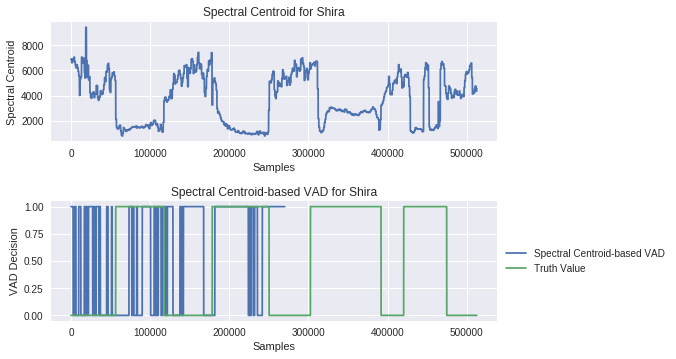

In [36]:
plt.subplots_adjust(hspace = 0.5)
plt.subplot(2,1,1)
spec_shira= spec_centroid(shira,0.02,fs)
plt.plot(spec_shira)
plt.xlabel('Samples')
plt.ylabel('Spectral Centroid')
plt.title('Spectral Centroid for Shira')
thresh_cent_shira = specthresh(spec_shira,0.02,fs,2000)
ax = plt.subplot(2,1,2)
plt.plot(thresh_cent_ash,label='Spectral Centroid-based VAD')
plt.plot(true_shira,label='Truth Value')
plt.xlabel('Samples')
plt.ylabel('VAD Decision')
plt.title('Spectral Centroid-based VAD for Shira')
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 1, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))



#### Accuracies' of the two audio samples

*   Ash's audio sample got an accuracy of 35.31%
*   Shira's audio sample got an accuracy of 23.5%

In [37]:

accuracy_ash,F1_score_ash,missclassifcation_ash = accuracy(true_ash,thresh_cent_ash)
accuracy_shira,F1_score_shira,missclassifcation_shira = accuracy(true_shira,thresh_cent_shira)
print('Ash-> Spectral Centroid VAD- (Simple threshold)')
print('Accuracy',accuracy_ash)
print('F1 Score',F1_score_ash)
print('Missclassifcation Score',missclassifcation_ash)
print('--------------------------------------------------')
print('Shira-> Spectral Centroid VAD- (Simple threshold)')
print('Accuracy',accuracy_shira)
print('F1 Score',F1_score_shira)
print('Missclassifcation Score',missclassifcation_shira)


Ash-> Spectral Centroid VAD- (Simple threshold)
Accuracy 0.3531494429959706
F1 Score 0.36929454587474
Missclassifcation Score 0.6468505570040294
--------------------------------------------------
Shira-> Spectral Centroid VAD- (Simple threshold)
Accuracy 0.23492690651522716
F1 Score 0.38047094977978013
Missclassifcation Score 0.7650730934847728


### Conclusion:
* Didn't perform well on it's own as can be seen, but, after seeing the plots, it has a good possibility to perform well when added with different features.

## Final Conclusion and Inference

We have seen 3 VADs, Energy, Spectral combinations and Spectral Centroid based, and reviewed each of their pros and cons.

To decide which algorithm would generalize for various speech recordings, I would say:

* For High SNR signals -> The **Energy-based VAD , Method 2**, which is based on adaptive threshold (Would have preferred Method 3 as the weight was automated , but I believe it needs to be optimized more for that )
* For Decreasing SNR -> The **Spectral combination -based VAD**, also based on adaptive threshold.

| SNR | Model  | Person  | Accuracy(%) | F1-Score(%)|Missclassifcation Score (%)|
| --- | --- | --- |--- | --- | --- | 
| Low SNR (possibly)| Spectral Combination VAD Model  | Shira | 99.72 | 99.74 |**0.28** |
| |  | Ash | 92.54 | 90.27 | 7.46|
|High SNR (possibly) | Energy-based VAD **Model 2** (adaptive threshold, manual weightage, | Shira | 98.36 | 98.5 | 1.64 |
| | manual minimum energy, hangover limit) | Ash | 95.58  | 94.42  |**4.42** |



### End Note 
Let's listen to the audio files generated by the two best models, shall we?



#### Spectral Combination VAD Model

In [38]:
# Shira's
ipd.Audio(enzcrtropy_thresh_shira*shira, rate=fs)

In [39]:
# Ash's
ipd.Audio(enzcrtropy_thresh_ash*ash, rate=fs)

#### Energy-based VAD Model- Method 2 (Adaptive Threshold)

In [40]:
# Shira's
ipd.Audio(athresh_shira*shira, rate=fs)

In [41]:
# Ash's
ipd.Audio(athresh_ash*ash, rate=fs)